In [1]:
import tensorflow as tf

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.0.0-rc0


In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [4]:
import pathlib

In [5]:
# data_dir = './dataset/2_class'
data_dir = 'E:\\study\\tensorflow\\data\\2_class'

In [6]:
data_root = pathlib.Path(data_dir)

In [7]:
data_root

WindowsPath('E:/study/tensorflow/data/2_class')

In [8]:
for item in data_root.iterdir():
    print(item)

E:\study\tensorflow\data\2_class\airplane
E:\study\tensorflow\data\2_class\lake


In [9]:
all_image_paths = list(data_root.glob('*/*'))

In [10]:
image_count = len(all_image_paths)

In [11]:
all_image_paths[:3]

[WindowsPath('E:/study/tensorflow/data/2_class/airplane/airplane_001.jpg'),
 WindowsPath('E:/study/tensorflow/data/2_class/airplane/airplane_002.jpg'),
 WindowsPath('E:/study/tensorflow/data/2_class/airplane/airplane_003.jpg')]

In [12]:
all_image_paths[-3:]

[WindowsPath('E:/study/tensorflow/data/2_class/lake/lake_698.jpg'),
 WindowsPath('E:/study/tensorflow/data/2_class/lake/lake_699.jpg'),
 WindowsPath('E:/study/tensorflow/data/2_class/lake/lake_700.jpg')]

In [13]:
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

1400

In [14]:
all_image_paths[:5]

['E:\\study\\tensorflow\\data\\2_class\\airplane\\airplane_383.jpg',
 'E:\\study\\tensorflow\\data\\2_class\\airplane\\airplane_526.jpg',
 'E:\\study\\tensorflow\\data\\2_class\\airplane\\airplane_207.jpg',
 'E:\\study\\tensorflow\\data\\2_class\\lake\\lake_064.jpg',
 'E:\\study\\tensorflow\\data\\2_class\\airplane\\airplane_534.jpg']

In [15]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['airplane', 'lake']

In [16]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'airplane': 0, 'lake': 1}

In [17]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [18]:
all_image_labels[:5]

[0, 0, 0, 1, 0]

In [19]:
import IPython.display as display

In [20]:
def caption_image(label):
    return {0: 'airplane', 1: 'lake'}.get(label)

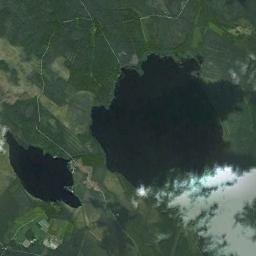

lake



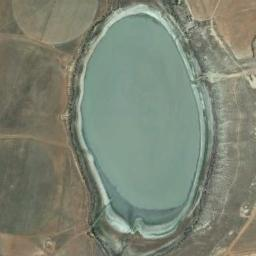

lake



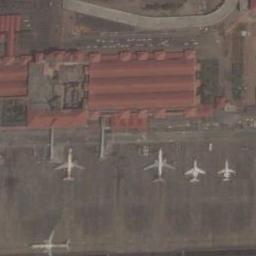

airplane



In [21]:
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index]))
    print(caption_image(all_image_labels[image_index]))
    print()

加载和格式化图像

In [22]:
img_path = all_image_paths[0]
img_path

'E:\\study\\tensorflow\\data\\2_class\\airplane\\airplane_383.jpg'

In [23]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [24]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 3)
<dtype: 'uint8'>


In [25]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_final = img_tensor/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(256, 256, 3)
0.0
1.0


In [26]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

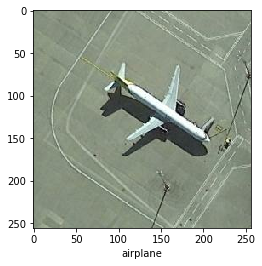

In [27]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(label))
print()

In [28]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [30]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [31]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

airplane
airplane
airplane
lake
airplane
airplane
airplane
lake
lake
airplane


In [32]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [33]:
image_label_ds

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [34]:
test_count = int(image_count*0.2)
train_count = image_count - test_count

In [35]:
train_data = image_label_ds.skip(test_count)

test_data = image_label_ds.take(test_count)

In [36]:
BATCH_SIZE = 32

In [37]:
train_data = train_data.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=train_count))
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [38]:
test_data = test_data.batch(BATCH_SIZE)

建立模型

In [39]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc']
)

In [42]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [43]:
history = model.fit(train_data, epochs=30, steps_per_epoch=steps_per_epoch, validation_data=test_data, validation_steps=validation_steps)

Train for 35 steps, validate for 8 steps
Epoch 1/30
35/35 [==============================] - 40s 1s/step - loss: 1.3115 - acc: 0.4830 - val_loss: 0.7299 - val_acc: 0.5117
Epoch 2/30
35/35 [==============================] - 27s 771ms/step - loss: 0.7016 - acc: 0.4705 - val_loss: 0.6753 - val_acc: 0.4883
Epoch 3/30
35/35 [==============================] - 27s 783ms/step - loss: 0.4216 - acc: 0.8402 - val_loss: 0.1405 - val_acc: 0.9453
Epoch 4/30
35/35 [==============================] - 27s 770ms/step - loss: 0.2015 - acc: 0.9375 - val_loss: 0.2436 - val_acc: 0.9414
Epoch 5/30
10/35 [=======>......................] - ETA: 18s - loss: 0.4209 - acc: 0.8993

KeyboardInterrupt: 

In [44]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

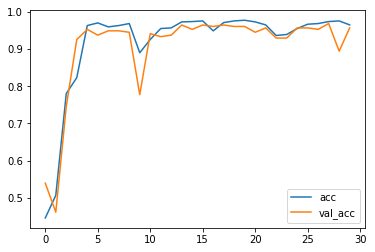

In [49]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

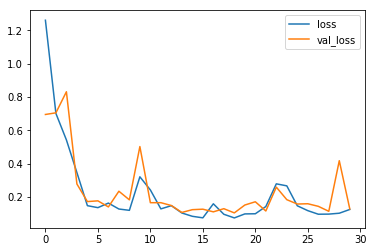

In [50]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()